In [1]:
from qbstyles import mpl_style
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation

In [2]:
mpl_style(dark=True)

## 1. Class for solutions and properties of the Na+K Model

In [3]:
import numpy as np
import scipy.optimize
import sys

# solver for NaKModel
class NaKModel:
    
    def __init__(self, V0, n0, delta=.001, fast_K=False, low_threshold_K=False):
        # Injected current
        self.I = 0
        # Initialize state variables
        self.V = V0
        self.n = n0
        self.Vdot = 0
        self.ndot = 0
        # Set step size
        self.delta = delta
        
        # Initialize constants depending on neuron type
        # Steady state IV relation
        self.V_k = 15
        self.V_v_half = -20
        # Steady state n
        self.n_k = 5
        if low_threshold_K:
            self.n_v_half = -45
        else:
            self.n_v_half = -25
        # Kinetics n
        if fast_K:
            self.tau = 0.152
        else:
            self.tau = 1
        # Neurophysiological properties
        if low_threshold_K:
            self.E_L = -78
        else:
            self.E_L = -80
        self.E_Na = 60
        self.E_K = -90
        self.g_L = 8
        self.g_Na = 20
        self.g_K = 10
        
        # Bifurcation occured?
        self.bifur=False
        
    # Steady state IV relation
    def steady_state_IV(self):
        return 1 / (1 + np.exp((self.V_v_half - self.V) / self.V_k))
    
    # Asymptotic behavior of n
    def steady_state_n(self, V=None):
        if not isinstance(V, type(None)):
            self.V = V
        return 1 / (1 + np.exp((self.n_v_half - self.V) / self.n_k))
    
    # Derivative n
    def activation_n(self):
        return (self.steady_state_n() - self.n) / self.tau 
    
    # V nullcline
    def v_nullcline(self, I=0):
        return (I - self.g_L * (self.V - self.E_L) - self.g_Na * self.steady_state_IV() * (self.V - self.E_Na)) / (self.g_K * (self.V - self.E_K))
    
    # Solve equilibria for I 
    def bifurcation_diagram(self, V):
        self.V = V
        return self.g_L * (self.V - self.E_L) + self.g_Na * self.steady_state_IV() * (self.V - self.E_Na) + self.g_K * self.steady_state_n() * (self.V - self.E_K) - self.I
    
    # Solve equilibria for V
    def equilibria(self, I=0, init=np.arange(-70, 20,30)):
        self.I = I
        if self.bifur:
            init = [1]
        try:
            x = scipy.optimize.broyden1(self.bifurcation_diagram, init)
            return np.unique(np.round(x, 4))
        except scipy.optimize.nonlin.NoConvergence as e: 
            self.bifur = True
    
    # Numerical Integration (Euler's Method)
    def step(self, I=0):
        # Derivative n
        self.ndot = self.activation_n()
        # Update n
        self.n += self.ndot * self.delta
        # Derivative V
        self.Vdot = I - self.g_L * (self.V - self.E_L) - self.g_Na * self.steady_state_IV() * (self.V - self.E_Na) - self.g_K * self.n * (self.V - self.E_K)
        # Update V
        self.V += self.Vdot * self.delta

In [31]:
#X, Y = np.meshgrid(np.linspace(-80, 20, 15), np.linspace(-.1, 1, 15))
#model = NaKModel(X,Y)
#model.step()
model.equilibria(I=4.53, init=[-60.9326, -60.9324, -27.0759])

/home/jonas/.venv/torch38/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([-60.9326, -60.9324, -27.0759])

## 2. Plot the phase portrait for a given instance of the Na+K model

<IPython.core.display.Javascript object>


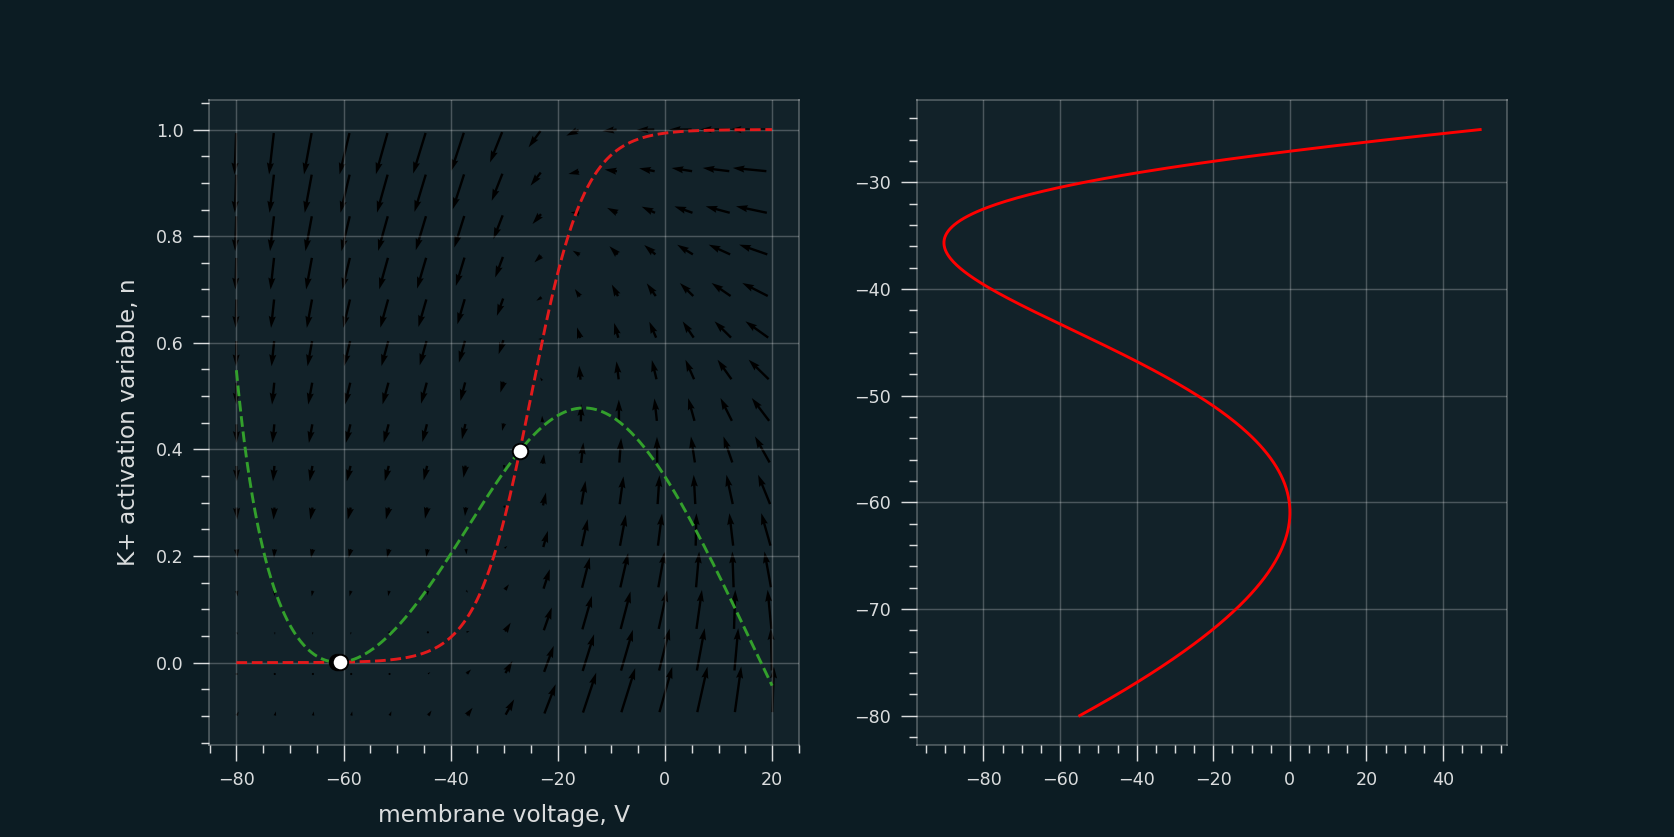

In [5]:
%matplotlib notebook
mpl_style(dark=True)
import matplotlib.pyplot as plt
from matplotlib import rc

fig, ax = plt.subplots(ncols=2, figsize=(12,6))
X, Y = np.meshgrid(np.linspace(-80, 20, 15), np.linspace(-.1, 1, 15))
x = np.linspace(-80, 20, 1000)
model = NaKModel(X,Y, fast_K=True)
model.step()
U = model.Vdot
V = model.ndot
model1 = NaKModel(x, np.zeros(1000))
n_nullcline = model1.steady_state_n()
V_nullcline = model1.v_nullcline(I = 4.5)

tm = ax[0].quiver(X, Y, U, V * 200)
ax[0].set(
    xlabel="membrane voltage, V",
    ylabel="K+ activation variable, n"
)

ax[0].plot(x, n_nullcline, linestyle='dashed')
ax[0].plot(x, V_nullcline, linestyle='dashed')

equi = model.equilibria(I=4.5)
ax[0].plot(equi[0], model.steady_state_n(equi[0]), 'o', color='black', ms=8)
ax[0].plot(equi[1:], model.steady_state_n(equi[1:]), 'o', markerfacecolor="white", markeredgecolor='black', ms=8)

I = model.bifurcation_diagram(x[x < -25])
ax[1].plot(I, x[x<-25], '-r')

In [12]:
model.equilibria(I=4.8)

array([-60.9684, -60.9256, -27.0634])

## 2. Animate a trajectory of the Na+K-model for any given pair of initial parameters

<IPython.core.display.Javascript object>


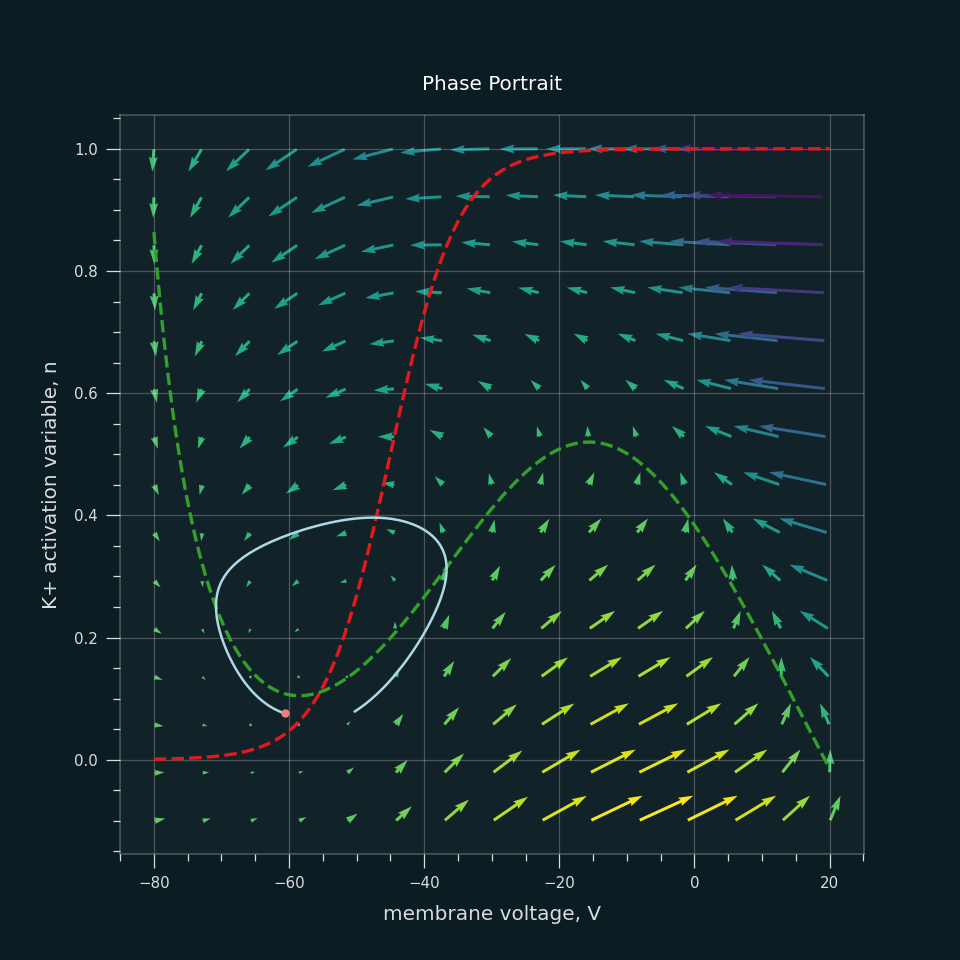

In [7]:
%matplotlib notebook
mpl_style(dark=True)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))

I = 20

X, Y = np.meshgrid(np.linspace(-80, 20, 15), np.linspace(-.1, 1, 15))
x = np.linspace(-80, 20, 1000)

model = NaKModel(X,Y, low_threshold_K=True)
model.step(I = I)
U = model.Vdot
V = model.ndot
model1 = NaKModel(x, np.zeros(1000), low_threshold_K=True)
n_nullcline = model1.steady_state_n()
V_nullcline = model1.v_nullcline(I = I)

tm = ax.quiver(X, Y, U, V * 200, U)
ax.set(
    title="Phase Portrait",
    xlabel="membrane voltage, V",
    ylabel="K+ activation variable, n"
)
ax.plot(x, n_nullcline, linestyle='dashed', lw=2)
ax.plot(x, V_nullcline, linestyle='dashed', lw=2)

xdata, ydata = [], []
ln, = ax.plot(xdata, ydata, '-', color='lightblue')
ln1, = ax.plot([], [], 'o', color='lightcoral')

model = 0
coords = []

def animate(frame):
    if model == 0:
        pass
    else:
        xdata.append(model.V)
        ydata.append(model.n)
        model.step(I = I)
        ln.set_data(xdata, ydata)
        ln1.set_data([xdata[-1]], [ydata[-1]])
    
    
def onclick(event):
    V0, n0 = event.xdata, event.ydata
    global model
    model = NaKModel(V0, n0, delta=.01, low_threshold_K=True)
    
    global coords
    coords.append((V0, n0))

    if len(coords) == 1:
        fig.canvas.mpl_disconnect(cid)
    
    return coords

cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()
ani = FuncAnimation(fig, animate, frames=200000, repeat=False, interval=20)
plt.show()

## 3. Animate Bifurcation on phase portrait and bifurcation diagram

<IPython.core.display.Javascript object>


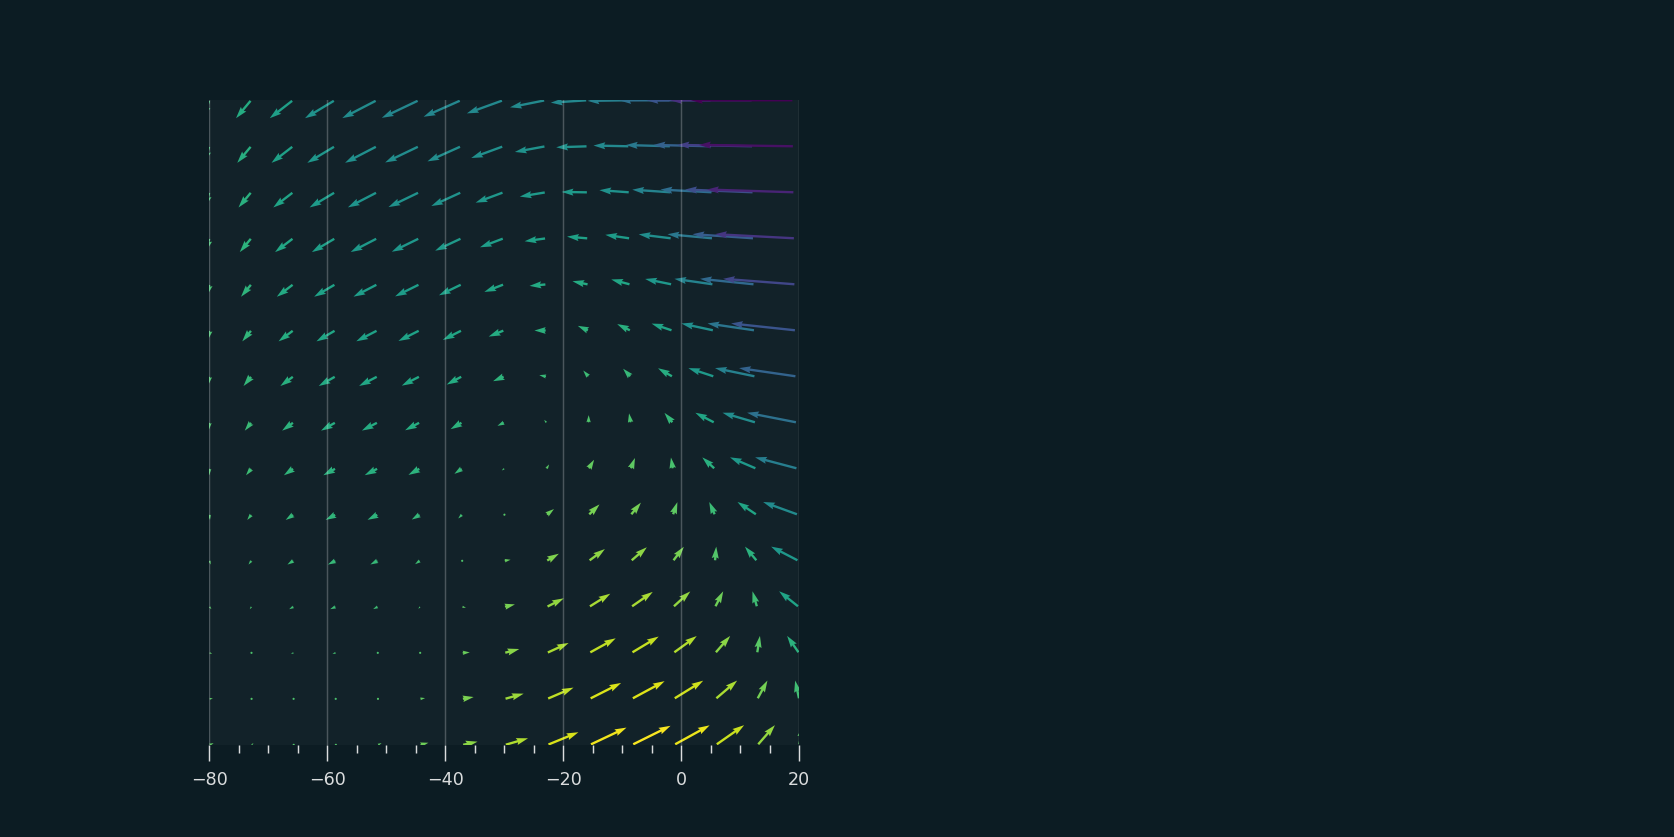

In [5]:
%matplotlib notebook
mpl_style(dark=True)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(ncols=2, figsize=(12,6))
X, Y = np.meshgrid(np.linspace(-80, 20, 15), np.linspace(-.1, 1.0, 15))
model = NaKModel(X,Y)

model2 = NaKModel(X,Y)
model2.step()
U = model2.Vdot
V = model2.ndot
qv = ax[0].quiver(X, Y, U, V * 200, U)

x = np.linspace(-80, 20, 1000)
model1 = NaKModel(x, np.zeros(1000))
n_nullcline = model1.steady_state_n()
ln, = ax[0].plot([],[], linestyle='dashed')

ax[0].set(
    title="Phase Portrait",
    xlabel="membrane voltage, V",
    ylabel="K+ activation variable, n",
    xlim=[-80, 20],
    ylim=[-.1, 1]
)

ax[1].set(
    title="Bifurcation Diagram",
    xlabel="injected current, I (bifurcation parameter)",
    ylabel="membrane voltage, V"
)

ax[0].plot(x, n_nullcline, linestyle='dashed', lw=2.5)
ln, = ax[0].plot([],[], linestyle='dashed', lw=2.5)
ln1, = ax[0].plot([],[], 'o', color='black', ms=8)
ln2, = ax[0].plot([],[], 'o', markerfacecolor="white", markeredgecolor='grey', ms=8)

I = model.bifurcation_diagram(x[x < -25])
ax[1].plot(I, x[x<-25], '-r', lw=3)
ln3, = ax[1].plot([],[], 'o', color='black', ms=8)
ln4, = ax[1].plot([],[], 'o', markerfacecolor="white", markeredgecolor='grey', ms=8)



def update(frame):
    X, Y = np.meshgrid(np.linspace(-80, 20, 15), np.linspace(-.1, 1.0, 15))
    model2.V = X
    model2.n = Y
    model2.step(I = frame)
    qv.set_UVC(model2.Vdot, model2.ndot * 200, model2.Vdot)
    
    V_nullcline = model1.v_nullcline(I = frame)
    ln.set_data(x, V_nullcline)
    
    try:
        equi = model.equilibria(I=frame, init=equi)
    except:
        equi = model.equilibria(I=frame)
    equi_n = model.steady_state_n(equi)
    
    try:
        if len(equi) == 3:
            ln1.set_data(equi[0], equi_n[0])
            ln3.set_data(frame, equi[0])
            ln2.set_data(equi[1:], equi_n[1:])
            ln4.set_data(frame, equi[1:])
        else:
            ln1.set_data(equi[0], equi_n[0])
            ln3.set_data(frame, equi[0])
    except:
        ln2.set_data([],[])
        ln4.set_data([],[])
        ln1.set_markerfacecolor("white")
        ln1.set_markeredgecolor('grey')
        ln3.set_markerfacecolor("white")
        ln3.set_markeredgecolor('grey')
    return ln


    
ani = FuncAnimation(fig, update, frames=np.linspace(-20,50,400), repeat=False, interval=60)
plt.show()
#ani.save("saddle_node_bifurcation_diagram_dark.mp4")

## 4. Animate bifuraction on different planes with injected ramp current 

<IPython.core.display.Javascript object>


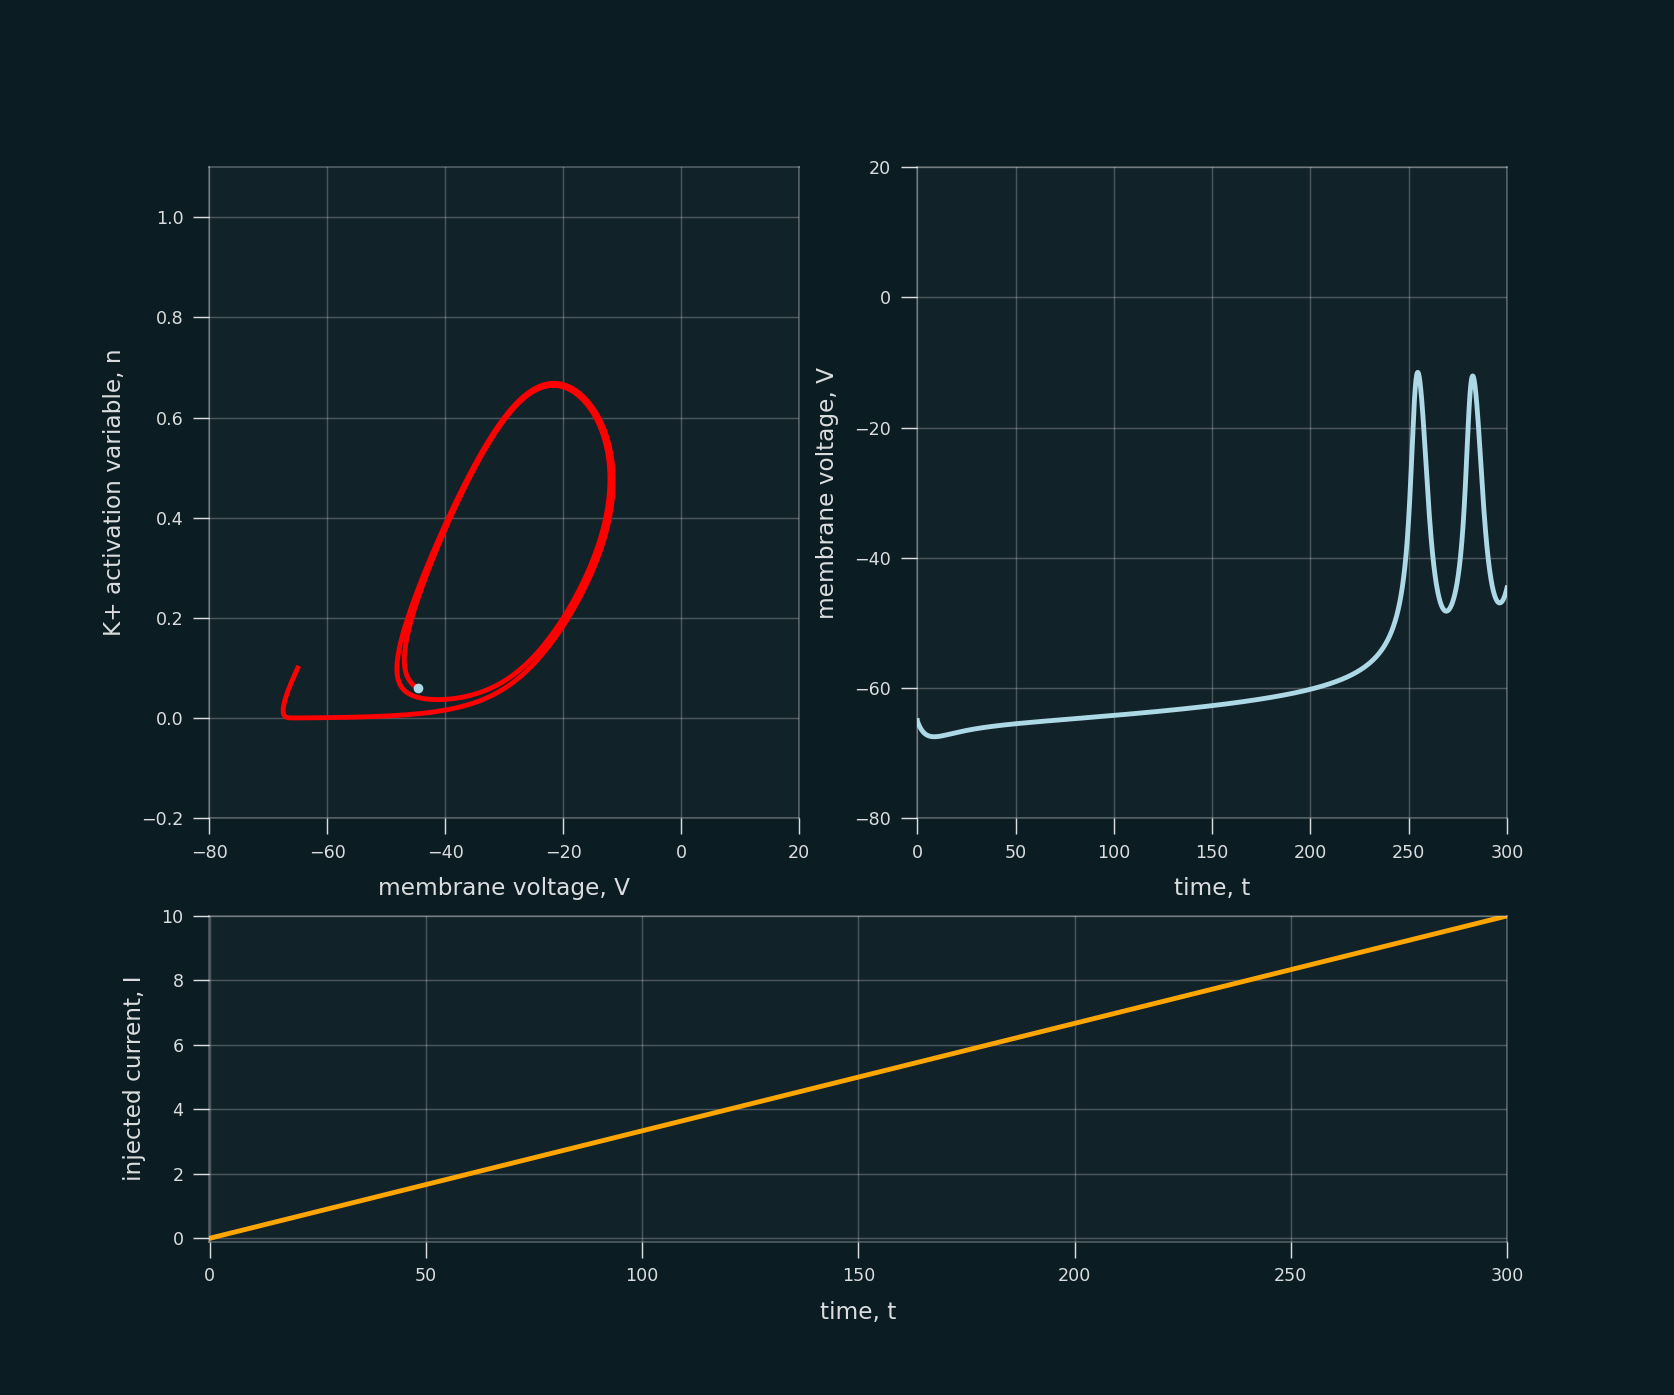

In [4]:
%matplotlib notebook
mpl_style(dark=True)

V0 = -65
n0 = .1

# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2, height_ratios=[1,0.5])
fig = plt.figure(figsize=(12,10))
ax1 = plt.subplot(gs[0, 0]) # row 0, col 0
ax2 = plt.subplot(gs[0, 1]) # row 0, col 1
ax3 = plt.subplot(gs[1, :]) # row 1, span all columns
ax = [ax1, ax2, ax3]

model = NaKModel(V0, n0, delta=.002, fast_K=True)
tdata, idata, xdata, ydata = [0], [0], [V0], [n0]
ln, = ax[0].plot(xdata, ydata, 'r-', lw=2.5)
ln1, = ax[1].plot(tdata, xdata, '-', lw=2.5, color='lightblue')
ln2, = ax[2].plot(tdata, idata, '-', lw=2.5, color='orange')
ln3, = ax[0].plot(xdata, ydata, 'o', ms=4, color='lightblue')
lines = [ln, ln1, ln2, ln3]

ax[0].set(
    xlabel="membrane voltage, V",
    ylabel="K+ activation variable, n"
)
ax[1].set(
    xlabel="time, t",
    ylabel="membrane voltage, V"
)
ax[2].set(
    xlabel="time, t",
    ylabel="injected current, I"
)
ax[0].set_xlim(-80, 20)
ax[0].set_ylim(-.2, 1.1)
ax[1].set_xlim(-.1, 300)
ax[1].set_ylim(-80, 20)
ax[2].set_xlim(-.1, 300)
ax[2].set_ylim(-.1, 10)


def update(frame):
    model.step(I=frame)
    idata.append(frame)
    xdata.append(model.V)
    ydata.append(model.n)
    tdata.append(frame * 30)
    lines[0].set_data(xdata, ydata)
    lines[1].set_data(tdata, xdata)
    lines[2].set_data(tdata, idata)
    lines[3].set_data(xdata[-1], ydata[-1])
    return lines
    


ani = FuncAnimation(fig, update, frames=np.linspace(0, 10, 10000), interval=4, repeat=False)
#ani.save("saddle_node_invariant_ramp_I_dark.mp4")
plt.show()